In [9]:
import json
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

In [2]:
with open("GD-VCR/val.jsonl", "r") as f:
    records = [json.loads(line) for line in f]

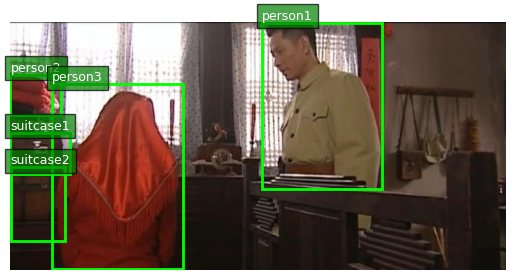

In [3]:
# Pick a record
record = records[5]

img_path = record["img_fn"]
json_path = record["metadata_fn"]
labels = record["objects"]

# Load image and metadata
image = Image.open(img_path)
with open(json_path) as f:
    metadata = json.load(f)
boxes = metadata["boxes"]  # [[x1, y1, x2, y2, score], ...]

# Dictionary to keep label counters
label_counter = {}

# Plot
fig, ax = plt.subplots()
ax.imshow(image)

for i, box in enumerate(boxes):
    x1, y1, x2, y2 = box[:4]
    label = labels[i] if i < len(labels) else "unknown"

    # Update counter and indexed label
    label_counter[label] = label_counter.get(label, 0) + 1
    indexed_label = f"{label}{label_counter[label]}"

    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                             linewidth=2, edgecolor='lime', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1 - 5, indexed_label, color='white',
            bbox=dict(facecolor='green', alpha=0.7), fontsize=9)

plt.axis('off')
plt.show()


In [4]:
def format_sequence(seq):
    """Helper function to flatten mixed text/token list (e.g., ["Rolling", "up", [2], "'s"] → 'Rolling up person3's')"""
    result = []
    for item in seq:
        if isinstance(item, list):
            result.append(f"person{item[0]+1}")  # +1 for 1-based indexing
        else:
            result.append(item)
    return ' '.join(result).replace(" 's", "'s").replace(" ,", ",").replace(" .", ".")

# Pick a record
record = records[5]

# Extract question and choices
question = format_sequence(record["question"])
choices = [format_sequence(choice) for choice in record["answer_choices"]]
correct_idx = record["answer_label"]
correct_answer = choices[correct_idx]

# Display
print("📌 Question:")
print(question)
print("\n🔢 Answer Choices:")
for i, choice in enumerate(choices):
    print(f"{i}. {choice}")

print(f"\n✅ Correct Answer: {correct_idx}. {correct_answer}")


📌 Question:
What are person1 going to participate in ?

🔢 Answer Choices:
0. They are college students and they are currently walking to class.
1. They are going to lifeboats on the sides of the ship.
2. They are going to have a wedding.
3. They will get in line with the others.

✅ Correct Answer: 2. They are going to have a wedding.


# EC-VCR

In [5]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# check version
print(detectron2.__version__)


0.6


In [6]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog
from detectron2 import model_zoo

import cv2

# Load config and pretrained model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
# Use COCO metadata (class names, colors, etc.)
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])  # COCO by default
class_names = metadata.thing_classes

predictor = DefaultPredictor(cfg)

[08/17 12:24:33 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


/home/gamil/miniconda3/envs/detectron2_env/lib/python3.10/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1752457306646/work/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


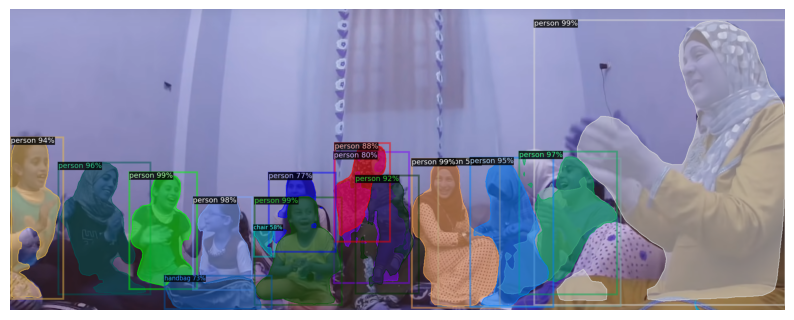

In [7]:
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt
import json
import os
from pycocotools import mask as mask_utils
import numpy as np


def segment_image(img_path:str):
    segOutputs_file_path = img_path[:img_path.find('.')]+'.json'
    # Read an image
    image = cv2.imread(img_path)
    outputs = predictor(image)
    instances = outputs["instances"]
    boxes = instances.pred_boxes.tensor.cpu().numpy()
    classes = instances.pred_classes.cpu().numpy()
    masks = instances.pred_masks.cpu().numpy()

    # Prepare annotation
    height, width = image.shape[:2]
    scores = instances.scores.cpu().numpy()
    boxes_list = []
    for box, score in zip(boxes, scores):
        x1, y1, x2, y2 = map(float, box.tolist())  # ensure Python float
        boxes_list.append([x1, y1, x2, y2, float(score)])

    # Convert masks to polygons
    segms = []
    for mask in masks:
        encoded = mask_utils.encode(np.asfortranarray(mask.astype(np.uint8)))
        contours = mask_utils.decode(encoded).astype(np.uint8)
        polys = cv2.findContours(contours, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
        for poly in polys:
            segms.append([[p[0][0], p[0][1]] for p in poly])

    fixed_segms = []
    for poly in segms:
        fixed_poly = [[int(p[0]), int(p[1])] for p in poly]
        fixed_segms.append([fixed_poly])

    # Prepare final dictionary with native types
    output_dict = {
        "width": int(width),
        "height": int(height),
        "boxes": boxes_list,
        "objects": [class_names[i] for i in classes],
        "segms": fixed_segms
    }


    # Save as JSON
    with open(segOutputs_file_path, "w") as f:
        json.dump(output_dict, f, indent=2)


    return outputs

def visualize_segImg(img_path, segOutputs):
    image = cv2.imread(img_path)
    # Outputs contain 'instances' with boxes, classes, and masks
    instances = segOutputs["instances"]

    # Use COCO metadata (class names, colors, etc.)
    metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])  # COCO by default

    # Visualize predictions
    v = Visualizer(image[:, :, ::-1], metadata=metadata, scale=1.0)
    out = v.draw_instance_predictions(instances.to("cpu"))

    # Show the result using matplotlib
    plt.figure(figsize=(10, 6))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis("off")
    plt.show()


img_id = 2 
visualize_segImg(f"EC-VCR/{img_id}.jpg", segment_image(f"EC-VCR/{img_id}.jpg"))


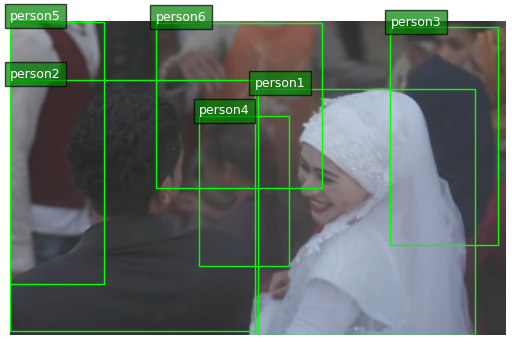

In [10]:
def visualize_img(img_path: str):
    json_path = img_path[:img_path.find('.')]+'.json'
    image = Image.open(img_path)
    with open(json_path) as f:
        metadata = json.load(f)
    labels = metadata['objects']
    boxes = metadata["boxes"]

    # Dictionary to keep label counters
    label_counter = {}

    # Plot
    fig, ax = plt.subplots()
    ax.imshow(image)

    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box[:4]
        label = labels[i] if i < len(labels) else "unknown"

        # Update counter and indexed label
        label_counter[label] = label_counter.get(label, 0) + 1
        indexed_label = f"{label}{label_counter[label]}"

        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                linewidth=1, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, indexed_label, color='white',
                bbox=dict(facecolor='green', alpha=0.7), fontsize=9)

    plt.axis('off')
    plt.show()

visualize_img("EC-VCR/17.jpg")

In [11]:
import yt_dlp

def parse_youtube_link(url):
    # 1. Extract the timestamp from the URL (in seconds)
    if "?t=" in url:
        timestamp = int(url.split("?t=")[-1])
        video_url = url.split("?t=")[0]
    elif "&t=" in url:
        timestamp = int(url.split("&t=")[-1])
        video_url = url.split("&t=")[0]
    else:
        raise ValueError("URL must contain a timestamp (?t=SECONDS)")
    
    #2. Use yt_dlp to get video metadata
    ydl_opts = {'quiet': True}
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(video_url, download=False)
        title = info.get('title', None)

    return title, timestamp, video_url


### Adding Questions

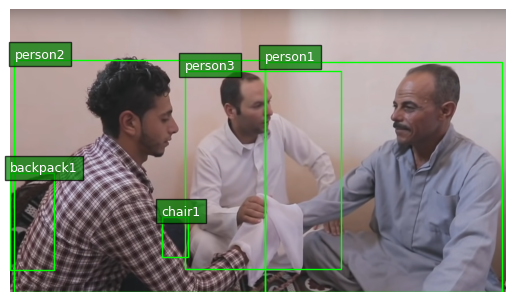

In [12]:
visualize_img("EC-VCR/0.jpg")

In [13]:
def add_question(timestamped_src_url:str, keywords:list, img_id, questions:list, choices:list, answer_indices:list, data_rootfolder='EC-VCR', questions_file="questions.jsonl"):
    img_fn = f"{data_rootfolder}/{img_id}.jpg"
    metadata_fn = f"{data_rootfolder}/{img_id}.json"
    
    if timestamped_src_url is not None:
        video_name, timestamp, link = parse_youtube_link(timestamped_src_url)

    with open(metadata_fn, "r") as f:
        metadata = json.load(f)
    objects = metadata.get("objects", [])
    
    def enumerate_objects_with_indices(objects):
        result = {}
        counts = {}  # to track how many times each object has been seen

        for index, obj in enumerate(objects):
            # Increment the count for this object
            counts[obj] = counts.get(obj, 0) + 1
            # Create the key in the format "object<count>"
            key = f"{obj}{counts[obj]}"
            # Store the index in a list
            result[key] = [index]

        return result

    obj_dict = enumerate_objects_with_indices(objects)
    result_questions = []

    for i, question_orig in enumerate(questions):
        question_entry = {}
        if timestamped_src_url is not None:
            question_entry["video_name"] = video_name
            question_entry["timestamp"] = timestamp
            question_entry["link"] = link

        question_entry["img_fn"] = img_fn
        question_entry["objects"] = objects
        question_entry["metadata_fn"] = metadata_fn
        question_entry["keywords"] = keywords
        question_entry["question_orig"] = question_orig.split()
        question = question_orig.split()
        for j, word in enumerate(question):
            if str(word).startswith('['):
                question[j] = obj_dict[word[1:len(word)-1]]
        question_entry['question'] = question

        answer_choices_for_question_i = choices[i]
        answer_orig = answer_choices_for_question_i[answer_indices[i]].split()
        for j, choice in enumerate(answer_choices_for_question_i):
            choice = choice.split()
            for k, word in enumerate(choice):
                if str(word).startswith('['):
                    choice[k] = obj_dict[word[1:len(word)-1]]
            answer_choices_for_question_i[j] = choice
        question_entry["answer_orig"] = answer_orig
        question_entry['answer_choices'] = answer_choices_for_question_i
        question_entry["answer_label"] = answer_indices[i]
        
        result_questions.append(question_entry)
    
    # Append each question entry as a JSON line to a .jsonl file
    output_path = questions_file
    with open(output_path, "a", encoding="utf-8") as f:
        for entry in result_questions:
            f.write(json.dumps(entry, ensure_ascii=False) + "\n")


In [14]:

add_question(timestamped_src_url=None,\
             data_rootfolder="EC-VCR", img_id=0, questions=["what is [person1] and [person2] doing ?", "what is [person3] job here ?"],\
                choices=[['[person1] is marrying [person2]', "[person2] is asking to marry [person1] daughter", "[person1] and [person2] are participating in 'katb el kitab'", "[person1] is fighting [person2]"],\
                         ["[person3] is a judge", "[person3] is a 'Maazoon", "[person3] is a lawyer", "[person3] doesn't have a job"]],\
                answer_indices=[2,1], keywords=["marriage", "wedding", "groom"])